In [1]:
!pip install transformers
!pip install numpy --upgrade

     |████████████████████████████████| 14.9 MB 4.2 MB/s eta 0:00:01
ERROR: tensorflow 2.3.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: allennlp 0.8.5 has requirement torch<1.2,>=0.4.1, but you'll have torch 1.7.1 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.15.1
    Uninstalling numpy-1.15.1:
      Successfully uninstalled numpy-1.15.1


In [1]:
import torch
import string

from transformers import BertTokenizer, BertForMaskedLM
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased').eval()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
def decode(tokenizer, pred_idx):
    ignore_tokens = string.punctuation + '[PAD]'
    tokens = []
    for w in pred_idx:
        token = ''.join(tokenizer.decode(w).split())
        if token not in ignore_tokens:
            tokens.append(token.replace('##', ''))
    return tokens


def encode(tokenizer, text_sentence, add_special_tokens=True):
    text_sentence = text_sentence.replace('<mask>', tokenizer.mask_token)
    if tokenizer.mask_token == text_sentence.split()[-1]:
        text_sentence += ' .'

    input_ids = torch.tensor([tokenizer.encode(text_sentence, add_special_tokens=add_special_tokens)])
    mask_idx = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]
    return input_ids, mask_idx


In [84]:
predicate = [ 
' is a',
#' is an',
#' has class',
#' has type',
#' is a particular',
#' is a specific',
#' is an individual',
#' is a unique',
#' is an example of',
#' has superclass',
#' is also a',
#' subtype of',
#' is a subtype of',
#' subcategory of',
#' is a category of',
#' is thereby also a',
#' is necessarily also a'
]



In [83]:
import json

with open('wikidata_P31.json', 'r') as wiki:
    wikidata = json.load(wiki)


0.967741935483871
16.06451612903226
1.0
0.967741935483871
0.06060755667704134



1.0
16.06451612903226
3.0
0.33333333333333337
0.06239967137238184



1.064516129032258
16.06451612903226
5.0
0.2129032258064517
0.06967354866523447



1.096774193548387
16.06451612903226
7.0
0.15668202764976957
0.07157108187206558



1.1612903225806452
16.06451612903226
10.0
0.11612903225806456
0.07518789516629823


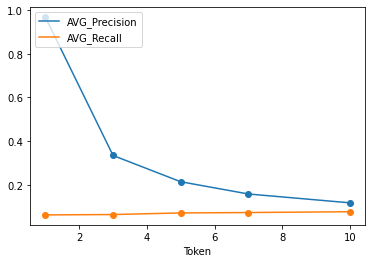

In [90]:
import random 
from tqdm import notebook

testcount = 0
countlist = []
LM_count = []
WK_count = []
precisionlist = []
recalllist = []
#r_wiki = random.sample(list(wikidata.items()), 10000)
#randomwiki = dict(r_wiki)
randomwiki = cola
token = [1,3,5,7,10]
avg_precision =[]
avg_recall = []

for t in token:
    countlist = []
    LM_count = []
    WK_count = []
    precisionlist = []
    recalllist = []
    for key in notebook.tqdm(randomwiki.keys()):
        #print(key)
        #print(randomwiki[key])
        if randomwiki[key] == [] :
            continue
        bertlist = set()
        for i in range(len(predicate)) :
            text_sentence = str(key) + predicate[i] + ' <mask>.'
            input_ids, mask_idx = encode(bert_tokenizer, text_sentence)

            with torch.no_grad():
                predict = bert_model(input_ids)[0]

            bert = decode(bert_tokenizer, predict[0, mask_idx, :].topk(10).indices.tolist())[:t]
            for k in range(len(bert)) :
                if bert[k] not in ['this','a','b','c','es','ii','iii'] :
                    bertlist.add(bert[k])
    
        bertlist = list(bertlist)
        LM_count.append(len(bertlist))
        WK_count.append(len(randomwiki[key]))
            
        count = 0
        for j in range(len(bertlist)) :
            if bertlist[j] in randomwiki[key] :
                #print(bertlist[j])
                count += 1
        countlist.append(count)        
            
        if len(randomwiki[key]) and len(bertlist) != 0 :
            precision = count/len(bertlist)
            recall = count/len(randomwiki[key])
            precisionlist.append(precision)
            recalllist.append(recall)
                  
        #print(count)
        #print(bertlist)
        #print(recall)
        #print(precision)
        #print(countlist)
    
        #testcount += 1
        #if testcount == 100:
        #   break
        
    AVG_LMxWK = sum(countlist, 0.0)/len(countlist)
    print(AVG_LMxWK)
    AVG_WKlist = sum(WK_count, 0.0)/len(WK_count)
    print(AVG_WKlist)
    AVG_LMlist = sum(LM_count, 0.0)/len(LM_count)
    print(AVG_LMlist)

    AVG_Precision = sum(precisionlist, 0.0)/len(precisionlist)
    avg_precision.append(AVG_Precision)
    print(AVG_Precision)
    AVG_Recall = sum(recalllist, 0.0)/len(recalllist)
    avg_recall.append(AVG_Recall)
    print(AVG_Recall)
    
import matplotlib.pyplot as plt

x=token
y=avg_precision
z=avg_recall
plt.scatter(x,y)
plt.scatter(x,z)
plt.plot(x,y, label='AVG_Precision')
plt.plot(x,z, label='AVG_Recall')
plt.legend(loc=2)
plt.xlabel('Token')
plt.savefig("precision_recall_abc.png")
plt.show()

In [75]:
readFile = 'popular.txt'
f = open(readFile, 'r')
popular = []
count = 0
for line in f:
    arr = line.split()
    del arr[-1]
    StrA = " ".join(arr)
    popular.append(StrA)
    count += 1
#print(popular)
#print(count)

pola = {}
for key, value in wikidata.items():
    if key in popular :
        pola[key] = value
#print(pola)

KeyboardInterrupt: 

In [89]:
from tqdm import notebook

readFile = 'sport.txt'
f = open(readFile, 'r')
country = []
count = 0
for line in f:
    country.append(line[:-1].lower()) #.lower()
    count += 1
#print(country)
print(count)

cola = {}
for key, value in notebook.tqdm(wikidata.items()):
    if key in country :
        cola[key] = value
#print(cola)

38


In [71]:
print(cola)

{'Badminton': [], 'Sailing': [], 'Tennis': [], 'Baseball': [], 'Basketball': [], 'Boxing': [], 'Golf': [], 'Football': [], 'Archery': [], 'Triathlon': [], 'Equestrian': [], 'Fencing': [], 'Handball': [], 'Wrestling': [], 'Judo': [], 'Aquatics': [], 'Softball': [], 'Karate': [], 'Taekwondo': [], 'Volleyball': [], 'Canoeing': [], 'Surfing': [], 'Rowing': [], 'Gymnastics': [], 'Shooting': [], 'Cycling': [], 'Athletics': [], 'Weightlifting': []}
